In [1]:
import keras
import tensorflow as tf

# Memory Pre-configuration
config = tf.compat.v1.ConfigProto(
    gpu_options=tf.compat.v1.GPUOptions(
        per_process_gpu_memory_fraction=0.9,
        allow_growth = True
    )
    # device_count = {'GPU': 1}
)
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

매우 적은 데이터를 사용하여 이미지 분류 모델을 훈련하는 것은 흔한 일입니다. 보통 **적은** 샘플이란 수백개에서 수만개 사이를 의미합니다. 이번 포스트에서는 4000개의 강아지와 고양이 사진으로 구성된 데이터셋에서 강아지와 고양이 이미지를 분류해보겠습니다.

문제를 해결하기 위해 기본적인 전략 하나를 살펴볼 것입니다. 보유한 소규모 데이터셋을 사용해서 처음부터 새로운 모델을 훈련하는 것입니다. 2000개의 훈련 샘플에서 작은 컨브넷을 어떤 규제 방법도 사용하지 않고 훈련하여 기준이 되는 기본 성능 모델을 만들겠습니다. 그 다음 **과대적합**을 줄이기 위한 방법인 **데이터 증식 (data augmentation)**을 사용할 것입니다. 그 다음에는 **사전 훈련된 네트워크로 특성을 추출하는 것**과 **사전 훈련된 네트워크를 세밀하게 튜닝하는 것**을 배울 것입니다.

### 작은 데이터셋 문제에서 딥러닝의 타당성

딥러닝은 데이터가 풍부해야지만 가능하다는 말이 있습니다. 딥러닝의 근본적인 특징은 훈련 데이터에서 특성 공학의 수작업 없이 흥미로운 특성을 찾을 수 있다는 것입니다. 이는 훈련 샘플이 많아야만 가능합니다. 입력 샘플이 이미지처럼 고차원인 경우 특히 그렇습니다.

하지만 많은 샘플이 의미하는 것은 상대적입니다. 훈련하려는 네트워크의 크기와 깊이에 상대적입니다. 복잡한 문제를 푸는 컨브넷을 수십 개의 샘플만 사용해서 훈련하는 것은 불가능합니다. 하지만 모델이 작고 규제가 잘 되어있는 간단한 작업이라면 수백 개의 샘플로도 충분할 수 있습니다.

컨브넷은 지역적이고 평행 이동으로 변하지 않는 특성을 학습하기때문에 지각에 관한 문제에서 매우 효율적으로 데이터를 사용합니다. 매우 작은 이미지 데이터셋에서 어떤 종류의 특성 공학을 사용하지 않더라도 컨브넷으로 처음부터 훈련해도 납득할만한 결과를 만들 수 있습니다.

### 데이터 내려받기

In [2]:
import os, shutil

original_data_set_dir = './data/dogs_and_cats/train/'

base_dir = './data/dogs_and_cats_small/'

train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

train_cats_dir = os.path.join(train_dir, "cats")
validation_cats_dir = os.path.join(validation_dir, "cats")
test_cats_dir = os.path.join(test_dir, "cats")

train_dogs_dir = os.path.join(train_dir, "dogs")
validation_dogs_dir = os.path.join(validation_dir, "dogs")
test_dogs_dir = os.path.join(test_dir, "dogs")   


try:
    os.mkdir(base_dir)

    os.mkdir(train_dir)
    os.mkdir(validation_dir)
    os.mkdir(test_dir)

    os.mkdir(train_cats_dir)
    os.mkdir(validation_cats_dir)
    os.mkdir(test_cats_dir)

    os.mkdir(train_dogs_dir)
    os.mkdir(validation_dogs_dir)
    os.mkdir(test_dogs_dir)

    fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
    for fname in fnames:
        src = os.path.join(original_data_set_dir, fname)
        dst = os.path.join(train_cats_dir, fname)
        shutil.copyfile(src, dst)

    fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
    for fname in fnames:
        src = os.path.join(original_data_set_dir, fname)
        dst = os.path.join(validation_cats_dir, fname)
        shutil.copyfile(src, dst)

    fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
    for fname in fnames:
        src = os.path.join(original_data_set_dir, fname)
        dst = os.path.join(test_cats_dir, fname)
        shutil.copyfile(src, dst)    


    fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
    for fname in fnames:
        src = os.path.join(original_data_set_dir, fname)
        dst = os.path.join(train_dogs_dir, fname)
        shutil.copyfile(src, dst)

    fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
    for fname in fnames:
        src = os.path.join(original_data_set_dir, fname)
        dst = os.path.join(validation_dogs_dir, fname)
        shutil.copyfile(src, dst)

    fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
    for fname in fnames:
        src = os.path.join(original_data_set_dir, fname)
        dst = os.path.join(test_dogs_dir, fname)
        shutil.copyfile(src, dst)

except:
    pass

In [3]:
print("훈련용 고양이 이미지 전체 개수:", len(os.listdir(train_cats_dir)))
print("검증용 고양이 이미지 전체 개수:", len(os.listdir(validation_cats_dir)))
print("테스트용 고양이 이미지 전체 개수:", len(os.listdir(test_cats_dir)))

print("훈련용 강아지 이미지 전체 개수:", len(os.listdir(train_dogs_dir)))
print("검증용 강아지 이미지 전체 개수:", len(os.listdir(validation_dogs_dir)))
print("테스트용 강아지 이미지 전체 개수:", len(os.listdir(test_dogs_dir)))

훈련용 고양이 이미지 전체 개수: 1000
검증용 고양이 이미지 전체 개수: 500
테스트용 고양이 이미지 전체 개수: 500
훈련용 강아지 이미지 전체 개수: 1000
검증용 강아지 이미지 전체 개수: 500
테스트용 강아지 이미지 전체 개수: 500


### 네트워크 구성하기

Conv2D 층과 MaxPooling2D 층을 번갈아 쌓은 컨브넷을 만들려 합니다. MNIST 문제보다 이미지가 크고 복잡한 문제이기 때문에 네트워크를 조금 더 크게 만들도록 하겠습니다.
* 150x150 크기의 입력으로 시작해서 Flatten층 이전에 7x7 크기의 특성 맵으로 줄어듭니다.
* 이진 분류 문제이므로 네트워크는 하나의 Dense 층과 Sigmoid 활성화 함수로 끝냅니다.

##### 소규모 컨브넷 만들기

In [4]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

컴파일 단계에서는 이전과 같이 RMSProp 옵티마이저를 선택하겠습니다. 네트워크의 마지막이 하나의 시그모이드 유닛이기떄문에 Binary Crossentropy를 손실로 사용합니다.

##### 모델의 훈련 설정하기

In [6]:
from keras import optimizers

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr = 1e-4),
              metrics = ['acc'])

### 데이터 전처리

데이터가 네트워크에 주입되기 전에 float 타입의 텐서로 전처리되어야 합니다. 데이터가 JPEG 파일로 되어있으므로 네트워크에 주입하려면:
1. 사진 파일을 읽습니다
2. JEPG 콘텐츠를 RGB 픽셀 값으로 디코딩합니다
3. 텐서로 변환합니다
4. 픽셀 값 (0 ~ 255 사이)의 스케일을 [0, 1] 사이로 조정합니다.

##### ImageDataGenerator를 사용하여 이미지 읽기

ImageDataGenerator는 이미지 파일을 전처리된 배치 텐서로 바꾸어주는 파이썬 제너레이터를 만들어줍니다.

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150,150),
                                                    batch_size = 20,
                                                    class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size = (150,150),
                                                        batch_size = 20,
                                                        class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


제너레이터의 출력을 살펴봅시다. 이 출력은 150x150 RGB 이미지의 배치 ((20, 150, 150, 3) 크기)와 이진 레이블의 배치 ((20,) 크기)입니다. 각 배치에는 20개의 샘플이 있습니다.

In [8]:
for data_batch, labels_batch in train_generator:
    print('배치 데이터 크기:', data_batch.shape)
    print('배치 레이블 크기:', labels_batch.shape)
    break

배치 데이터 크기: (20, 150, 150, 3)
배치 레이블 크기: (20,)


* fit_generator 메서드는 fit 메서드와 동일하되 데이터 제너레이터를 사용할 수 있습니다.
* 매개변수로 입력과 배치를 반환하는 파이썬 제너레이터를 기대합니다
* 데이터가 끝없이 생성되기 때문에 제너레이터로 부터 얼마나 많은 샘플을 뽑을지 알려주어야 합니다
* `steps_per_epoch` 횟수만큼 SGD 단계를 실행한 후 다음 에포크로 넘어갑니다
* 여기서는 20개의 샘플이 하나의 배치임으로 2,000개의 샘플을 모두 배치할때까지 100개의 배치를 뽑습니다.

##### 배치 제너레이터를 사용하여 모델 훈련하기

In [9]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = 100,
                              epochs = 30,
                              validation_data = validation_generator,
                              validation_steps = 50)

Epoch 1/30


/home/jhhur/anaconda3/envs/TIL2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


100/100 [==============================] - 11s 53ms/step - loss: 0.6954 - acc: 0.5103 - val_loss: 0.6964 - val_acc: 0.5170
Epoch 2/30
100/100 [==============================] - 4s 43ms/step - loss: 0.6620 - acc: 0.5863 - val_loss: 0.6417 - val_acc: 0.6350
Epoch 3/30
100/100 [==============================] - 4s 43ms/step - loss: 0.6134 - acc: 0.6591 - val_loss: 0.5995 - val_acc: 0.6900
Epoch 4/30
100/100 [==============================] - 4s 42ms/step - loss: 0.5717 - acc: 0.6963 - val_loss: 0.5851 - val_acc: 0.6940
Epoch 5/30
100/100 [==============================] - 4s 43ms/step - loss: 0.5394 - acc: 0.7212 - val_loss: 0.5893 - val_acc: 0.6910
Epoch 6/30
100/100 [==============================] - 4s 43ms/step - loss: 0.4954 - acc: 0.7593 - val_loss: 0.5540 - val_acc: 0.7240
Epoch 7/30
100/100 [==============================] - 4s 43ms/step - loss: 0.4638 - acc: 0.7739 - val_loss: 0.5581 - val_acc: 0.7070
Epoch 8/30
100/100 [==============================] - 4s 42ms/step - loss: 0.44

##### 모델 저장하기

In [10]:
model.save("cats_and_dogs_small_1.h5")

##### 훈련의 정확도와 손실 그래프 그리기

<Figure size 432x288 with 0 Axes>

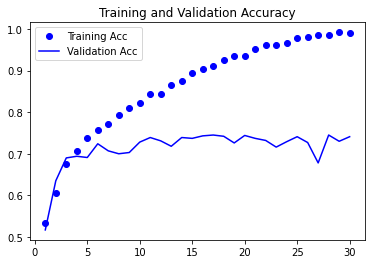

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label = "Training Acc")
plt.plot(epochs, val_acc, "b", label = "Validation Acc")
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

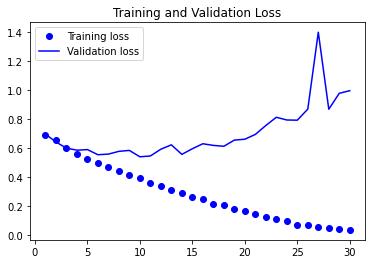

In [12]:
plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

이 그래프는 과대적합의 특성을 보여줍니다. 
* 훈련 정확도가 시간이 지남에 따라 선형적으로 증가해서 거의 100%에 도달합니다. 
* 반면 검증 정확도는 60~70%에서 멈추었습니다.
* 검증 손실은 다섯번의 에포크만에 최솟값에 다다른 이후 더 이상 진전되지 않았습니다
* 훈련 손실은 거의 0에 도달할때까지 선형적으로 계속 감사합니다.

훈련 샘플의 수가 2000개로 적기 때문에 과대적합이 가장 중요한 문제입니다. 여기에서는 CV에 일반적으로 사용되는 데이터 증식 (Data Augmentation)을 시도해보겠습니다.

### 데이터 증식

데이터 증식은 기존 훈련 샘플로부터 더 많은 훈련 데이터를 생성하는 방법입니다. 이 방법은 그럴듯한 이미지를 생성하도록 여러가지 랜덤한 변환을 적용하여 샘플을 늘립니다.

##### ImageDataGenerator를 사용하여 데이터 증식 설정하기

In [13]:
datagen = ImageDataGenerator(rotation_range = 20,
                             width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             shear_range = 0.1,
                             zoom_range = 0.1,
                             horizontal_flip = True,
                             fill_mode = 'nearest')

* rotation_range: 랜덤하게 사진을 회전시킬 각도 범위
* width_shift_range, height_shift_range: 사진을 수평과 수 직으로 랜덤하게 평행 이동 시키는 범위
* shear_range: 랜덤하게 shearing transformation을 적용할 각도 범위
* zoom_range: 랜덤하게 사진을 확대할 범위
* horizontal_flip: 랜덤하게 이미지를 수평으로 뒤집을지 여부
* fill_mode:  회전이나 가로/세로 이동으로 인해 새롭게 생성해야 할 픽셀을 채우는 방법

##### 랜덤하게 증식된 훈련 이미지 그리기

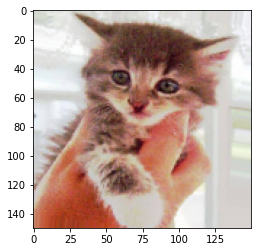

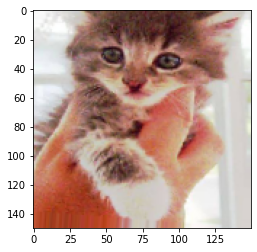

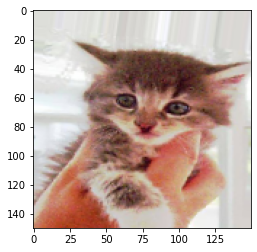

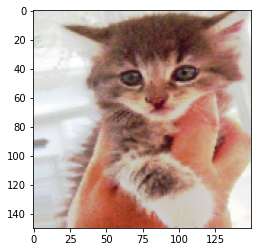

In [14]:
from keras.preprocessing import image

fnames = sorted([os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)])

## 증식할 이미지 선택
img_path = fnames[3] 

## 이미지를 읽고 크기를 변경합니다
img = image.load_img(img_path, target_size = (150, 150))

x = image.img_to_array(img) ## (150, 150, 3) 크기의 넘파이 배열로 변환
x = x.reshape((1,) + x.shape) ## (1, 150, 150, 3) 크기로 변환

i = 0

## 랜덤하게 변환된 이미지 배치를 생성합니다
## 무한 반복되기에 언제 멈출지 명시해야합니다.
for batch in datagen.flow(x, batch_size = 1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
        
plt.show()

데이터 증식을 사용하여 새로운 샘플 데이터를 만들면 원본 이미지에서 만들어졌기 때문에 여전히 입력 데이터들 사이에 상호 연관성이 큽니다. 즉 새로운 정보를 만들어 낼 수 없고 단지 기존 정보의 재조합만 가능합니다. 그렇기 때문에 완전히 과대적합을 제거하기에 충분하지 않을 수 있습니다. 과대적합을 더 억제하기 위해 Dropout 층을 추가합니다.

##### 드랍아웃을 포함한 새로운 컨브넷 정의하기

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr = 1e-4),
              metrics = ['acc'])

##### 데이터 증식 제너레이터를 이용하여 컨브넷 훈련하기

In [16]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150, 150),
                                                    batch_size = 20,
                                                    class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                    target_size = (150, 150),
                                                    batch_size = 20,
                                                    class_mode = 'binary')

history = model.fit_generator(train_generator,
                              steps_per_epoch = (2000 // 20),
                              epochs = 100,
                              validation_data = validation_generator,
                              validation_steps = 50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100


/home/jhhur/anaconda3/envs/TIL2/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


100/100 [==============================] - 10s 94ms/step - loss: 0.6966 - acc: 0.4778 - val_loss: 0.6863 - val_acc: 0.5460
Epoch 2/100
100/100 [==============================] - 9s 87ms/step - loss: 0.6894 - acc: 0.5443 - val_loss: 0.6711 - val_acc: 0.5930
Epoch 3/100
100/100 [==============================] - 9s 86ms/step - loss: 0.6768 - acc: 0.5757 - val_loss: 0.6996 - val_acc: 0.5380
Epoch 4/100
100/100 [==============================] - 9s 86ms/step - loss: 0.6637 - acc: 0.5734 - val_loss: 0.6663 - val_acc: 0.5760
Epoch 5/100
100/100 [==============================] - 9s 85ms/step - loss: 0.6574 - acc: 0.5771 - val_loss: 0.6702 - val_acc: 0.5760
Epoch 6/100
100/100 [==============================] - 9s 85ms/step - loss: 0.6528 - acc: 0.5960 - val_loss: 0.6289 - val_acc: 0.6330
Epoch 7/100
100/100 [==============================] - 9s 86ms/step - loss: 0.6314 - acc: 0.6181 - val_loss: 0.6340 - val_acc: 0.6220
Epoch 8/100
100/100 [==============================] - 9s 86ms/step - los

Epoch 62/100
100/100 [==============================] - 9s 86ms/step - loss: 0.4694 - acc: 0.7785 - val_loss: 0.4804 - val_acc: 0.7720
Epoch 63/100
100/100 [==============================] - 9s 86ms/step - loss: 0.4792 - acc: 0.7781 - val_loss: 0.4698 - val_acc: 0.7770
Epoch 64/100
100/100 [==============================] - 9s 86ms/step - loss: 0.4345 - acc: 0.8016 - val_loss: 0.5017 - val_acc: 0.7620
Epoch 65/100
100/100 [==============================] - 9s 86ms/step - loss: 0.4681 - acc: 0.7700 - val_loss: 0.5541 - val_acc: 0.7320
Epoch 66/100
100/100 [==============================] - 9s 87ms/step - loss: 0.4517 - acc: 0.7859 - val_loss: 0.4591 - val_acc: 0.7800
Epoch 67/100
100/100 [==============================] - 9s 88ms/step - loss: 0.4625 - acc: 0.7774 - val_loss: 0.5027 - val_acc: 0.7500
Epoch 68/100
100/100 [==============================] - 9s 92ms/step - loss: 0.4740 - acc: 0.7668 - val_loss: 0.4669 - val_acc: 0.7860
Epoch 69/100
100/100 [==============================] -

In [17]:
model.save('cats_and_dogs_small_2.h5')

결과 그래프를 다시 그려봅시다. 데이터 증식과 드롭아웃 덕택에 더 이상 과대적합되지 않습니다. 훈련 곡선이 검증 곡선에 가깝게 따라가고 있습니다.

<Figure size 432x288 with 0 Axes>

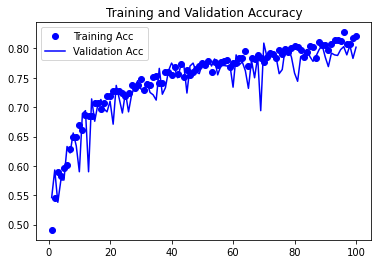

<Figure size 432x288 with 0 Axes>

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label = "Training Acc")
plt.plot(epochs, val_acc, "b", label = "Validation Acc")
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

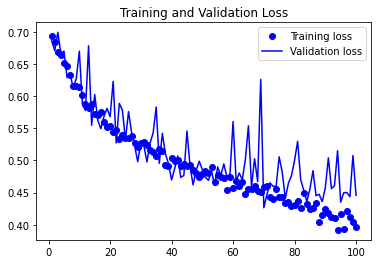

In [19]:
plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title('Training and Validation Loss')
plt.legend()

plt.show()